Simulation summary
------------------
dt = 1.0 ms, sensor delay = 3.0 ms, k_assist = 0.70
RMS human torque (no assist): 10.29 N·m
RMS human torque (assist):    1.18 N·m
Estimated reduction:          88.5%


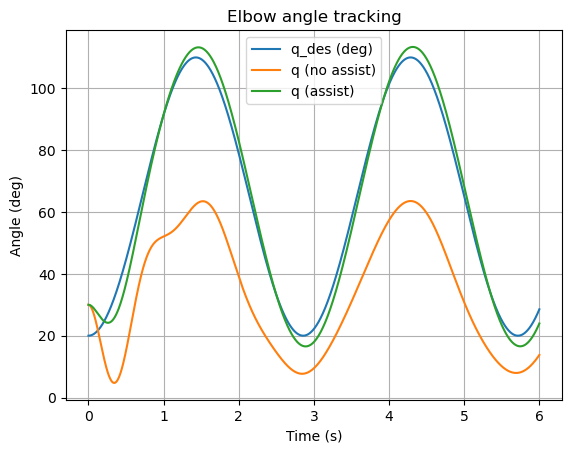

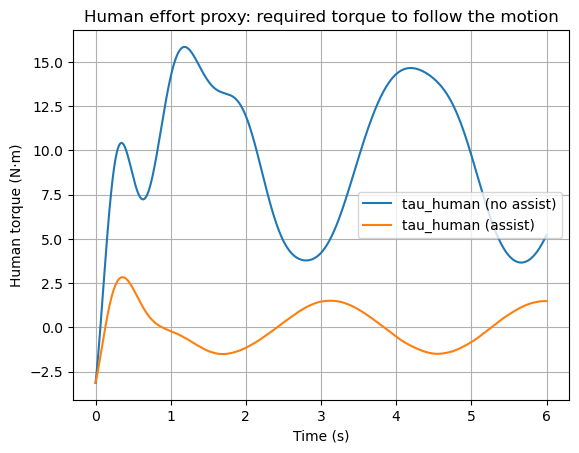

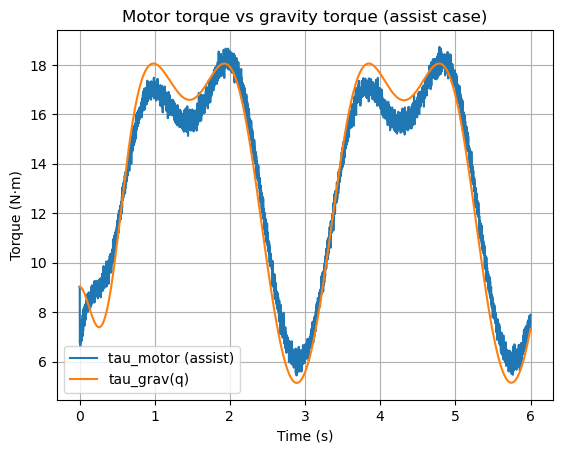

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1-DOF elbow "curl" simulation
# -----------------------------
# Goal: show whether a "transparent + load cancellation" controller can reduce
# the human-required torque while preserving the desired motion.
#
# Model:
#   I*qdd = tau_motor + tau_human - tau_grav(q) - b*qdot
#
# Human model (intent proxy):
#   tau_human = Kp_h*(q_des - q) + Kd_h*(qd_des - qdot)
#
# Cuff force sensor model:
#   F_cuff = tau_human / r_cuff + noise
#   tau_h_hat = F_cuff * r_cuff
#
# Motor control (your concept, MVP):
#   tau_motor = tau_grav_hat(q) + k_assist * tau_h_hat - B*qdot
#
# Compare:
#   Case A: no assist (tau_motor = 0)
#   Case B: assist (tau_motor as above)

# -----------------------------
# Parameters (reasonable MVP defaults)
# -----------------------------
g = 9.81

# Geometry (planar)
L = 0.32          # forearm length (m)
L_com = 0.15      # forearm COM from elbow (m)
r_cuff = 0.12     # effective moment arm from elbow to cuff force application (m)

# Mass/inertia
m_arm = 1.6       # effective forearm+hand mass (kg)
m_load = 5.0      # external load at hand (kg) (e.g., dumbbell)
I_arm = 0.025     # approximate forearm inertia about elbow (kg*m^2)
I_load = m_load * L**2
I = I_arm + I_load

# Passive damping at the joint
b = 0.08          # N*m*s/rad

# Human "intent" controller gains (how hard the person tries to follow q_des)
Kp_h = 18.0       # N*m/rad
Kd_h = 1.5        # N*m*s/rad

# Motor assistance settings
k_assist = 0.7    # 0..1 for safe amplification in this simplified sim
B = 0.6           # virtual damping (N*m*s/rad)

# Sensor sampling & noise
dt = 0.001        # 1 ms control timestep
T = 6.0
N = int(T/dt)
sensor_noise_std_N = 2.5  # N RMS noise on cuff force

# Optional sensor delay (to stress stability); set to 0..5 ms
sensor_delay_s = 0.003
delay_steps = int(sensor_delay_s / dt)

# Torque limits (simulate real actuator limits)
tau_motor_limit = 45.0    # N*m

# -----------------------------
# Desired motion (human intent trajectory)
# -----------------------------
t = np.arange(N) * dt
# Curl-like motion between 20 and 110 degrees
q0 = np.deg2rad(20.0)
q_amp = np.deg2rad(45.0)  # +/- amplitude
freq = 0.35               # Hz
q_des = q0 + q_amp * (1 - np.cos(2*np.pi*freq*t))  # smooth raise and lower
qd_des = np.gradient(q_des, dt)

# -----------------------------
# Gravity torque model
# q = 0 rad -> arm extended forward (horizontal), q positive -> curling upward
# Using sin(q) form for gravitational moment about elbow.
# -----------------------------
def tau_grav(q):
    return (m_arm*g*L_com + m_load*g*L) * np.sin(q)

# -----------------------------
# Simulation function
# -----------------------------
def simulate(with_assist: bool):
    q = np.zeros(N)
    qd = np.zeros(N)
    q[0] = np.deg2rad(30.0)
    qd[0] = 0.0

    tau_h = np.zeros(N)
    tau_m = np.zeros(N)
    F_cuff = np.zeros(N)
    tau_h_hat = np.zeros(N)

    # Delay line for tau_h_hat (simulates filtering + sensor + compute latency)
    delay_line = np.zeros(delay_steps + 1)

    for k in range(N-1):
        # Human "intent" torque (tries to follow q_des)
        tau_h[k] = Kp_h*(q_des[k] - q[k]) + Kd_h*(qd_des[k] - qd[k])

        # Cuff force sensor reading (what you'd measure at the interface)
        F_cuff[k] = (tau_h[k] / r_cuff) + np.random.normal(0.0, sensor_noise_std_N)
        tau_h_hat_now = F_cuff[k] * r_cuff

        # Apply sensor delay
        delay_line = np.roll(delay_line, 1)
        delay_line[0] = tau_h_hat_now
        tau_h_hat[k] = delay_line[-1]

        # Motor control
        if with_assist:
            # Gravity compensation + assistance + virtual damping
            tau_cmd = tau_grav(q[k]) + k_assist * tau_h_hat[k] - B*qd[k]
        else:
            tau_cmd = 0.0

        # Saturate motor torque
        tau_cmd = np.clip(tau_cmd, -tau_motor_limit, tau_motor_limit)
        tau_m[k] = tau_cmd

        # Plant dynamics
        qdd = (tau_m[k] + tau_h[k] - tau_grav(q[k]) - b*qd[k]) / I

        # Integrate
        qd[k+1] = qd[k] + qdd*dt
        q[k+1] = q[k] + qd[k+1]*dt

    # Last sample fill
    tau_h[-1] = tau_h[-2]
    tau_m[-1] = tau_m[-2]
    F_cuff[-1] = F_cuff[-2]
    tau_h_hat[-1] = tau_h_hat[-2]

    return q, qd, tau_h, tau_m, F_cuff, tau_h_hat

# Run both cases (same random seed for fair comparison)
np.random.seed(7)
q_A, qd_A, tau_h_A, tau_m_A, F_A, tau_h_hat_A = simulate(with_assist=False)
np.random.seed(7)
q_B, qd_B, tau_h_B, tau_m_B, F_B, tau_h_hat_B = simulate(with_assist=True)

# -----------------------------
# Plots
# -----------------------------
plt.figure()
plt.plot(t, np.rad2deg(q_des), label="q_des (deg)")
plt.plot(t, np.rad2deg(q_A), label="q (no assist)")
plt.plot(t, np.rad2deg(q_B), label="q (assist)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (deg)")
plt.title("Elbow angle tracking")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, tau_h_A, label="tau_human (no assist)")
plt.plot(t, tau_h_B, label="tau_human (assist)")
plt.xlabel("Time (s)")
plt.ylabel("Human torque (N·m)")
plt.title("Human effort proxy: required torque to follow the motion")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, tau_m_B, label="tau_motor (assist)")
plt.plot(t, tau_grav(q_B), label="tau_grav(q)")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N·m)")
plt.title("Motor torque vs gravity torque (assist case)")
plt.legend()
plt.grid(True)

# Summaries
def rms(x): return np.sqrt(np.mean(x**2))
effort_reduction = 100.0 * (1.0 - rms(tau_h_B)/rms(tau_h_A))

print("Simulation summary")
print("------------------")
print(f"dt = {dt*1e3:.1f} ms, sensor delay = {sensor_delay_s*1e3:.1f} ms, k_assist = {k_assist:.2f}")
print(f"RMS human torque (no assist): {rms(tau_h_A):.2f} N·m")
print(f"RMS human torque (assist):    {rms(tau_h_B):.2f} N·m")
print(f"Estimated reduction:          {effort_reduction:.1f}%")

plt.show()
